In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 4
batch_size = 64
epochs = 50
learning_rate = 1e-3

In [3]:
def load_data(input_file):
    """
    Load waveform data from CSV.
    Expects waveform columns to start with 't'.
    """
    df = pd.read_csv(input_file)
    waveforms = df[[c for c in df.columns if c.startswith("t")]].values
    return df, waveforms


In [4]:
run_id = "run0010"
layer_id = 1
x = 1
y = 1
input_file = f"../data/X7/{run_id}/layer{layer_id}_x{x}_y{y}.csv"
#run_id = "run0004"
#layer_id = 4
#x = 2
#y = 0
#input_file = f"../data/shiyan/{run_id}/layer{layer_id}_x{x}_y{y}.csv"
print(f"Loading file: {input_file}")
df, waveforms = load_data(input_file)
print(f"Loaded {len(waveforms)} waveforms with shape {waveforms.shape}")

Loading file: ../data/X7/run0010/layer1_x1_y1.csv
Loaded 22353 waveforms with shape (22353, 1000)


In [5]:
# Normalize waveforms to [-1, 1]
def normalize_waveforms(waveforms):
    min_vals = waveforms.min(axis=1, keepdims=True)
    max_vals = waveforms.max(axis=1, keepdims=True)
    scaled = 2 * (waveforms - min_vals) / (max_vals - min_vals + 1e-8) - 1
    return scaled, min_vals, max_vals


In [29]:
waveforms_norm, min_vals, max_vals = normalize_waveforms(waveforms)
T = waveforms_norm.shape[1]
reduced_T = T // 4

In [7]:
class WaveformDataset(Dataset):
    def __init__(self, waveforms):
        self.waveforms = torch.tensor(waveforms, dtype=torch.float32).unsqueeze(1)  # (N, 1, T)
    def __len__(self):
        return self.waveforms.shape[0]
    def __getitem__(self, idx):
        return self.waveforms[idx], self.waveforms[idx]

In [8]:
class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * reduced_T, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * reduced_T),
            nn.Unflatten(1, (32, reduced_T)),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

In [9]:
def train_autoencoder(model, dataloader, epochs, lr):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, _ = model(x)
            loss = criterion(x_hat, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)

        avg_loss = total_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        print(f"Epoch {epoch}: Loss = {avg_loss:.6f}")

    return losses


In [10]:
def plot_latent_space(model, dataset, n=500):
    model.eval()
    with torch.no_grad():
        inputs, _ = zip(*[dataset[i] for i in range(min(n, len(dataset)))])
        inputs = torch.stack(inputs).to(device)
        _, z = model(inputs)
        z = z.cpu().numpy()
        plt.figure(figsize=(6, 6))
        plt.scatter(z[:, 0], z[:, 1], s=10, alpha=0.7)
        plt.title("Latent Space Projection (first 2 dims)")
        plt.xlabel("z1")
        plt.ylabel("z2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [11]:
dataset = WaveformDataset(waveforms_norm)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = CNNAutoencoder(latent_dim=latent_dim)
losses = train_autoencoder(model, dataloader, epochs, learning_rate)

Epoch 0: Loss = 0.039648
Epoch 1: Loss = 0.002777
Epoch 2: Loss = 0.002720
Epoch 3: Loss = 0.002655
Epoch 4: Loss = 0.002542
Epoch 5: Loss = 0.002445
Epoch 6: Loss = 0.002366
Epoch 7: Loss = 0.002317
Epoch 8: Loss = 0.002280
Epoch 9: Loss = 0.002249
Epoch 10: Loss = 0.002226
Epoch 11: Loss = 0.002200
Epoch 12: Loss = 0.002185
Epoch 13: Loss = 0.002169
Epoch 14: Loss = 0.002154
Epoch 15: Loss = 0.002144
Epoch 16: Loss = 0.002134
Epoch 17: Loss = 0.002128
Epoch 18: Loss = 0.002121
Epoch 19: Loss = 0.002118
Epoch 20: Loss = 0.002112
Epoch 21: Loss = 0.002107
Epoch 22: Loss = 0.002105
Epoch 23: Loss = 0.002100
Epoch 24: Loss = 0.002100
Epoch 25: Loss = 0.002095
Epoch 26: Loss = 0.002094
Epoch 27: Loss = 0.002091
Epoch 28: Loss = 0.002089
Epoch 29: Loss = 0.002086
Epoch 30: Loss = 0.002086
Epoch 31: Loss = 0.002084
Epoch 32: Loss = 0.002089
Epoch 33: Loss = 0.002084
Epoch 34: Loss = 0.002079
Epoch 35: Loss = 0.002080
Epoch 36: Loss = 0.002075
Epoch 37: Loss = 0.002079
Epoch 38: Loss = 0.002

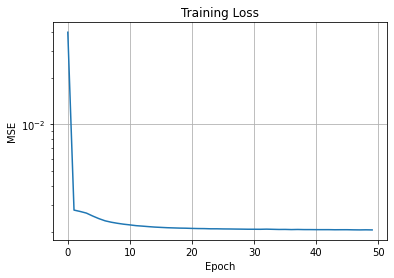

In [12]:
# Plot loss
plt.plot(losses)
plt.yscale("log")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.show()


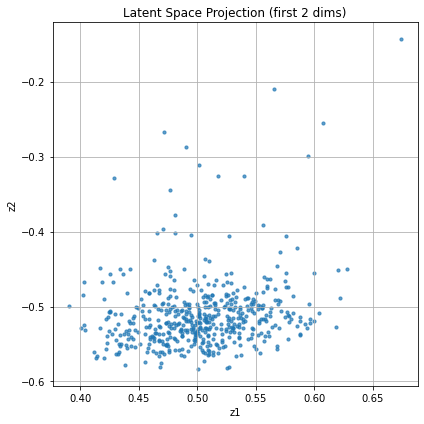

In [13]:
# Visualize latent space
if latent_dim >= 2:
    plot_latent_space(model, dataset, n=500)


In [14]:
def plot_reconstruction(model, dataset, n=5, indices=None):
    """
    Plot original and reconstructed waveforms.
    
    Parameters:
        model: trained autoencoder
        dataset: WaveformDataset instance
        n: number of random waveforms to plot (ignored if indices is given)
        indices: list of specific indices to plot
    """
    model.eval()
    
    if indices is None:
        total = len(dataset)
        indices = np.random.choice(total, size=min(n, total), replace=False)
    
    with torch.no_grad():
        fig, axs = plt.subplots(len(indices), 1, figsize=(10, 2 * len(indices)), sharex=True)
        if len(indices) == 1:
            axs = [axs]  # handle case of single plot
        for i, idx in enumerate(indices):
            x, _ = dataset[idx]
            x_input = x.unsqueeze(0).to(device)
            x_hat, _ = model(x_input)
            original = x.squeeze().cpu().numpy()
            reconstructed = x_hat.squeeze().cpu().numpy()

            axs[i].plot(original, label="Original", alpha=0.6)
            axs[i].plot(reconstructed, label="Reconstructed", linestyle="--")
            axs[i].legend()
            axs[i].set_title(f"Waveform {idx}")
            axs[i].grid(True)

        plt.tight_layout()
        plt.show()

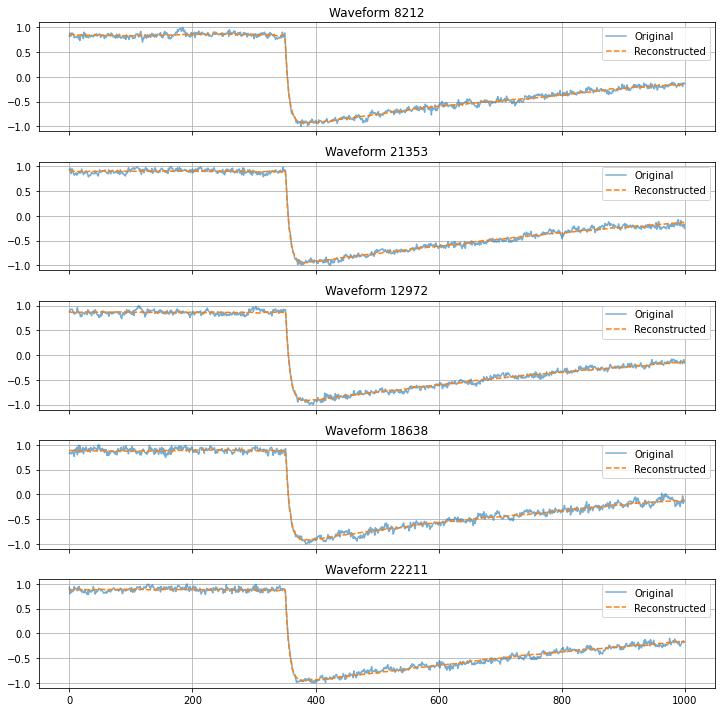

In [15]:
plot_reconstruction(model, dataset, n=5)
#plot_reconstruction(model, dataset, indices=[6688,9779,3133], n=5)

In [16]:
def rescale_waveforms(normalized, min_vals, max_vals):
    return (normalized + 1) / 2 * (max_vals - min_vals) + min_vals

In [17]:
import yaml
import sys
from pathlib import Path

# Add 'scripts' folder to Python path
base_dir = Path.cwd().parent  # assumes you're in 'base/notebooks'
scripts_dir = base_dir / 'scripts'
sys.path.append(str(scripts_dir))

# Now you can import your module
import MWD_utils

In [18]:
# load config
mwd_params_path = "../config/test_run0010.yaml"
def run_mwd(waveforms, mwd_params_path, quiet=False):
    from MWD_utils import MWD
    with open(mwd_params_path, "r") as f:
        mwd_config = yaml.safe_load(f)
    mwd_params = mwd_config.get("final_parameters", mwd_config)
    mwd_energies = []
    for wf in tqdm(waveforms, desc="MWD energy calculation", disable=quiet):
        _, energy, _ = MWD_utils.MWD(wf, mwd_params)
        mwd_energies.append(energy)
    return np.array(mwd_energies)

In [26]:
energies_orig = run_mwd(waveforms, mwd_params_path)

MWD energy calculation: 100%|████████████| 22353/22353 [02:33<00:00, 145.30it/s]


In [31]:
model.eval()
with torch.no_grad():
    denoised_waveforms = []
    for x_batch, _ in dataloader:
        x_batch = x_batch.to(device)
        x_hat, _ = model(x_batch)
        denoised = x_hat.squeeze(1).cpu().numpy()  # shape: (batch_size, T)
        denoised_waveforms.append(denoised)
# Stack all batches into a full array
denoised_waveforms = np.vstack(denoised_waveforms)  # shape: (n_waveforms, T)
denoised_rescaled = rescale_waveforms(denoised_waveforms, min_vals, max_vals)

In [32]:
energies_denoised = run_mwd(denoised_rescaled, mwd_params_path)

MWD energy calculation: 100%|████████████| 22353/22353 [02:32<00:00, 146.70it/s]


In [33]:
from MWD_utils import fit_energy_spectrum, gaussian
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def compare_mwd_energy_spectra(energies_orig, energies_denoised, bins=200, fit=True):
    # Compute shared histogram bins
    all_energies = np.concatenate([energies_orig, energies_denoised])
    hist_range = (all_energies.min(), all_energies.max())
    
    # Compute histograms
    counts_orig, edges = np.histogram(energies_orig, bins=bins, range=hist_range)
    counts_denoised, _ = np.histogram(energies_denoised, bins=bins, range=hist_range)
    centers = (edges[:-1] + edges[1:]) / 2

    plt.figure(figsize=(10, 5))
    plt.plot(centers, counts_orig, label="Original", alpha=0.6)
    plt.plot(centers, counts_denoised, label="Denoised", alpha=0.6)

    if fit:
        # Fit both and overlay Gaussian
        _, _, mu_o, sig_o, res_o = fit_energy_spectrum(energies_orig, bins=bins)
        _, _, mu_d, sig_d, res_d = fit_energy_spectrum(energies_denoised, bins=bins)

        if mu_o and sig_o:
            plt.plot(centers, gaussian(centers, max(counts_orig), mu_o, sig_o),
                     linestyle="--", label=f"Orig Fit: μ={mu_o:.3f}, σ={sig_o:.3f}, R={res_o:.3f}%")

        if mu_d and sig_d:
            plt.plot(centers, gaussian(centers, max(counts_denoised), mu_d, sig_d),
                     linestyle="--", label=f"Denoised Fit: μ={mu_d:.3f}, σ={sig_d:.3f}, R={res_d:.3f}%")

    plt.xlabel("Energy")
    plt.ylabel("Counts")
    #plt.xlim(10,130)
    plt.title("MWD Energy Spectra: Original vs Denoised")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

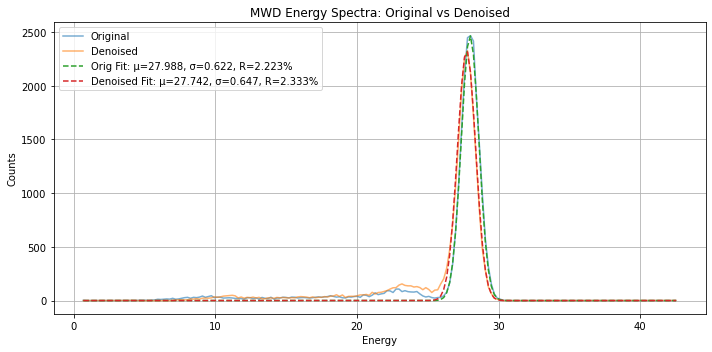

In [34]:
compare_mwd_energy_spectra(energies_orig, energies_denoised)

In [35]:
run_id = "run0010"
layer_id = 2
x = 2
y = 2
input_file = f"../data/X7/{run_id}/layer{layer_id}_x{x}_y{y}.csv"
print(f"Loading file: {input_file}")
df_new, waveforms_new = load_data(input_file)
print(f"Loaded {len(waveforms_new)} waveforms with shape {waveforms_new.shape}")

Loading file: ../data/X7/run0010/layer2_x2_y2.csv
Loaded 14694 waveforms with shape (14694, 1000)


In [36]:
waveforms_new_norm, min_vals, max_vals  = normalize_waveforms(waveforms_new)

In [37]:
dataset_new = WaveformDataset(waveforms_new_norm)
dataloader_new = DataLoader(dataset_new, batch_size=batch_size, shuffle=False)


In [38]:
model.eval()
denoised_new = []
with torch.no_grad():
    for x_batch, _ in dataloader_new:
        x_batch = x_batch.to(device)
        x_hat, _ = model(x_batch)
        denoised = x_hat.squeeze(1).cpu().numpy()
        denoised_new.append(denoised)

denoised_new = np.vstack(denoised_new)
print("Denoised waveforms shape:", denoised_new.shape)

Denoised waveforms shape: (14694, 1000)


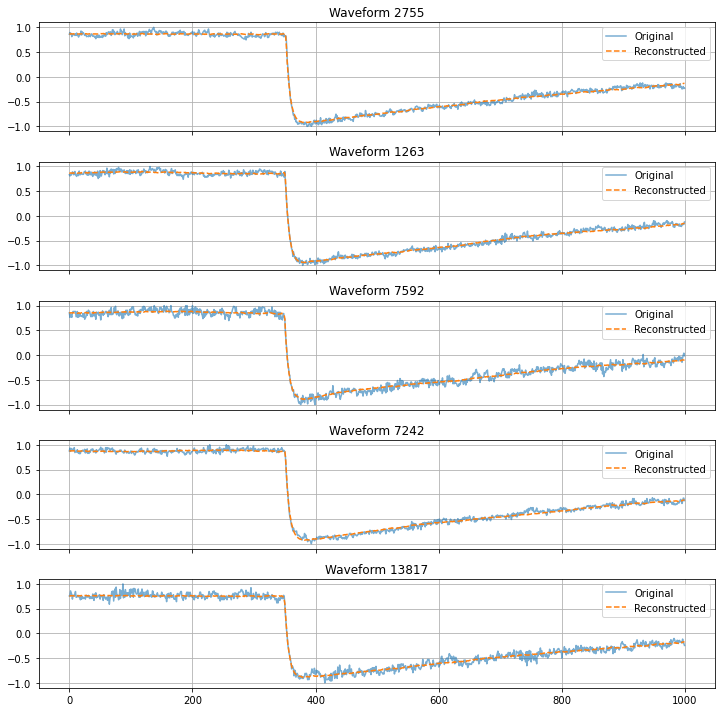

In [39]:
plot_reconstruction(model, dataset_new, n=5)

In [40]:
denoised_rescaled = rescale_waveforms(denoised_new, min_vals, max_vals)
energies_orig_new = run_mwd(waveforms, mwd_params_path)
energies_denoised_new = run_mwd(denoised_rescaled, mwd_params_path)


MWD energy calculation: 100%|████████████| 14694/14694 [01:42<00:00, 143.22it/s]


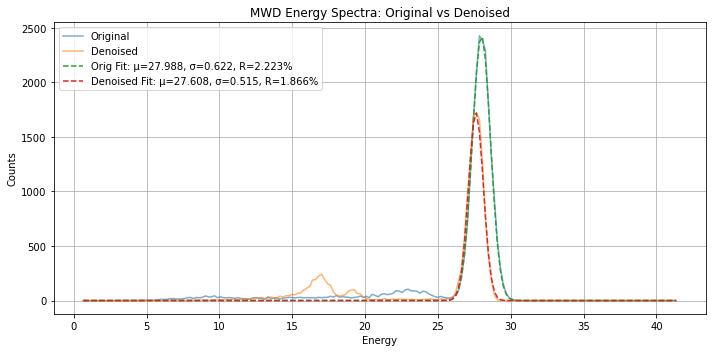

In [41]:
compare_mwd_energy_spectra(energies_orig_new, energies_denoised_new)
